In [ ]:
pip install SALib

In [ ]:
import sys

from SALib.sample import saltelli,finite_diff, fast_sampler
from SALib.analyze import morris,sobol, dgsm, fast, delta
from SALib.util import read_param_file
from SALib.sample.morris import sample
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms

import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv2D, Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
import keras
import pandas
import math
from sklearn.metrics import mean_squared_error,f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc
import copy
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import os
import pandas as pd

import sys
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/SA/data"
model_path = "/content/drive/My Drive/SA/model"

In [ ]:
feature_labels = np.load(os.path.join(data_path, "featurelabels_v7.npy"), fix_imports=True, encoding='latin1')[1:]
clf = keras.models.load_model(os.path.join(model_path, 'dnn_v1_hgroup_2.h5'))
realnames = np.load(os.path.join(data_path, "featurelabels_real.npy"),allow_pickle = True, fix_imports=True,encoding='latin1').item()

In [ ]:
feature_labels_new=[]
for f in feature_labels:
    f = f.decode('utf-8')
    if (f in realnames.keys()):
        rn = realnames[f].replace(" ", "_")
        feature_labels_new.append(rn)
    else:
        feature_labels_new.append(f.replace(" ", "_"))


In [ ]:
problem = {
  'num_vars': 369,
  'names': list(feature_labels_new),
  'bounds': [[0.0, 1.0]]*369 #standard scaled
}

**Morris**

Morris method is known as a "One at a time" method, where only one parameter is changed at each simulation. Each input parameter may assume a discrete number of values, called levels, which are chosen within the paramter range of variation.




The variation of the objective function $F$ in relation to a parameter $X_i$ is calculated by finite difference between two sets of identical parameters with the exception of a single parameter. Thus, if there are $d$ parameters, we need $d+1$ simulations to assess the effect of a variation in each of them, i.e. $\frac{\Delta F}{\Delta X_1}, \frac{\Delta F}{\Delta X_2}, ..., \frac{\Delta F}{\Delta X_d}$.

* $\mu*$ is the average of the distribution of the absolute values of the elementary effects. 
* $\mu*$ is used to detect input parameters with an important overall
influence on the output. 
* $\sigma$ is used to detect parameters involved in
interaction with other parameters or whose effect is non-linear.
* If the standard deviation of the series of elementary effects is small, the effect is considered linear. 
* If this standard deviation is large the effect is non-linear or causes interactions with other parameters.
* If the mean of $\mu$ is high, it implies not only that the parameter has
a large effect on the output but also that the sign of this effect is
always the same. 
* If the mean of $\mu$ is low, while the
mean of $\mu*$ is high, it means that the parameter examined has effects of
different signs depending on the point in space at which the effect
is computed.



In [ ]:
## 1- Morris
from SALib.analyze import morris
from SALib.sample.morris import sample
X = sample(problem, N=300, num_levels=4, optimal_trajectories=None)

Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()


si_morris = morris.analyze(problem, X, Y, conf_level=0.95, 
                    print_to_console=False,
                    num_levels=4, num_resamples=100)

In [ ]:
si_morris.keys()

dict_keys(['names', 'mu', 'mu_star', 'sigma', 'mu_star_conf'])

In [ ]:
def sort_Si(Si, key, sortby):
    return np.array([Si[key][x] for x in np.argsort(Si[sortby])])


In [ ]:
names_sorted = sort_Si(si_morris, 'names', sortby='mu_star')
mu_star_sorted = sort_Si(si_morris, 'mu_star', sortby='mu_star')
sigma_sorted = sort_Si(si_morris, 'sigma', sortby='mu_star')
mu_star_conf_sorted = sort_Si(si_morris, 'mu_star_conf', sortby='mu_star')
mu_sorted = sort_Si(si_morris, 'mu', sortby='mu_star')


In [ ]:
print(mu_star_sorted[-10:-1])
print(sigma_sorted[-10:-1])

[0.00692896 0.00704393 0.00707987 0.00711598 0.00765746 0.00780532
 0.00980716 0.01039075 0.01147781]
[0.05189306 0.06242784 0.05340461 0.04898477 0.05937946 0.06068014
 0.07108939 0.08570855 0.07641671]


In [ ]:
mu_star = si_morris['mu_star'] 
sigma = si_morris['sigma']
effective_par = 0;indlist=[]
ind = -1
for m,s in zip(mu_star,sigma):
   ind+=1
   if m>=s:
     effective_par+=1
     indlist.append(ind)
     print(m,s,ind)
   
print('number of effective parameters {}, indexes {}'.format(effective_par,indlist))

number of effective parameters 0, indexes []


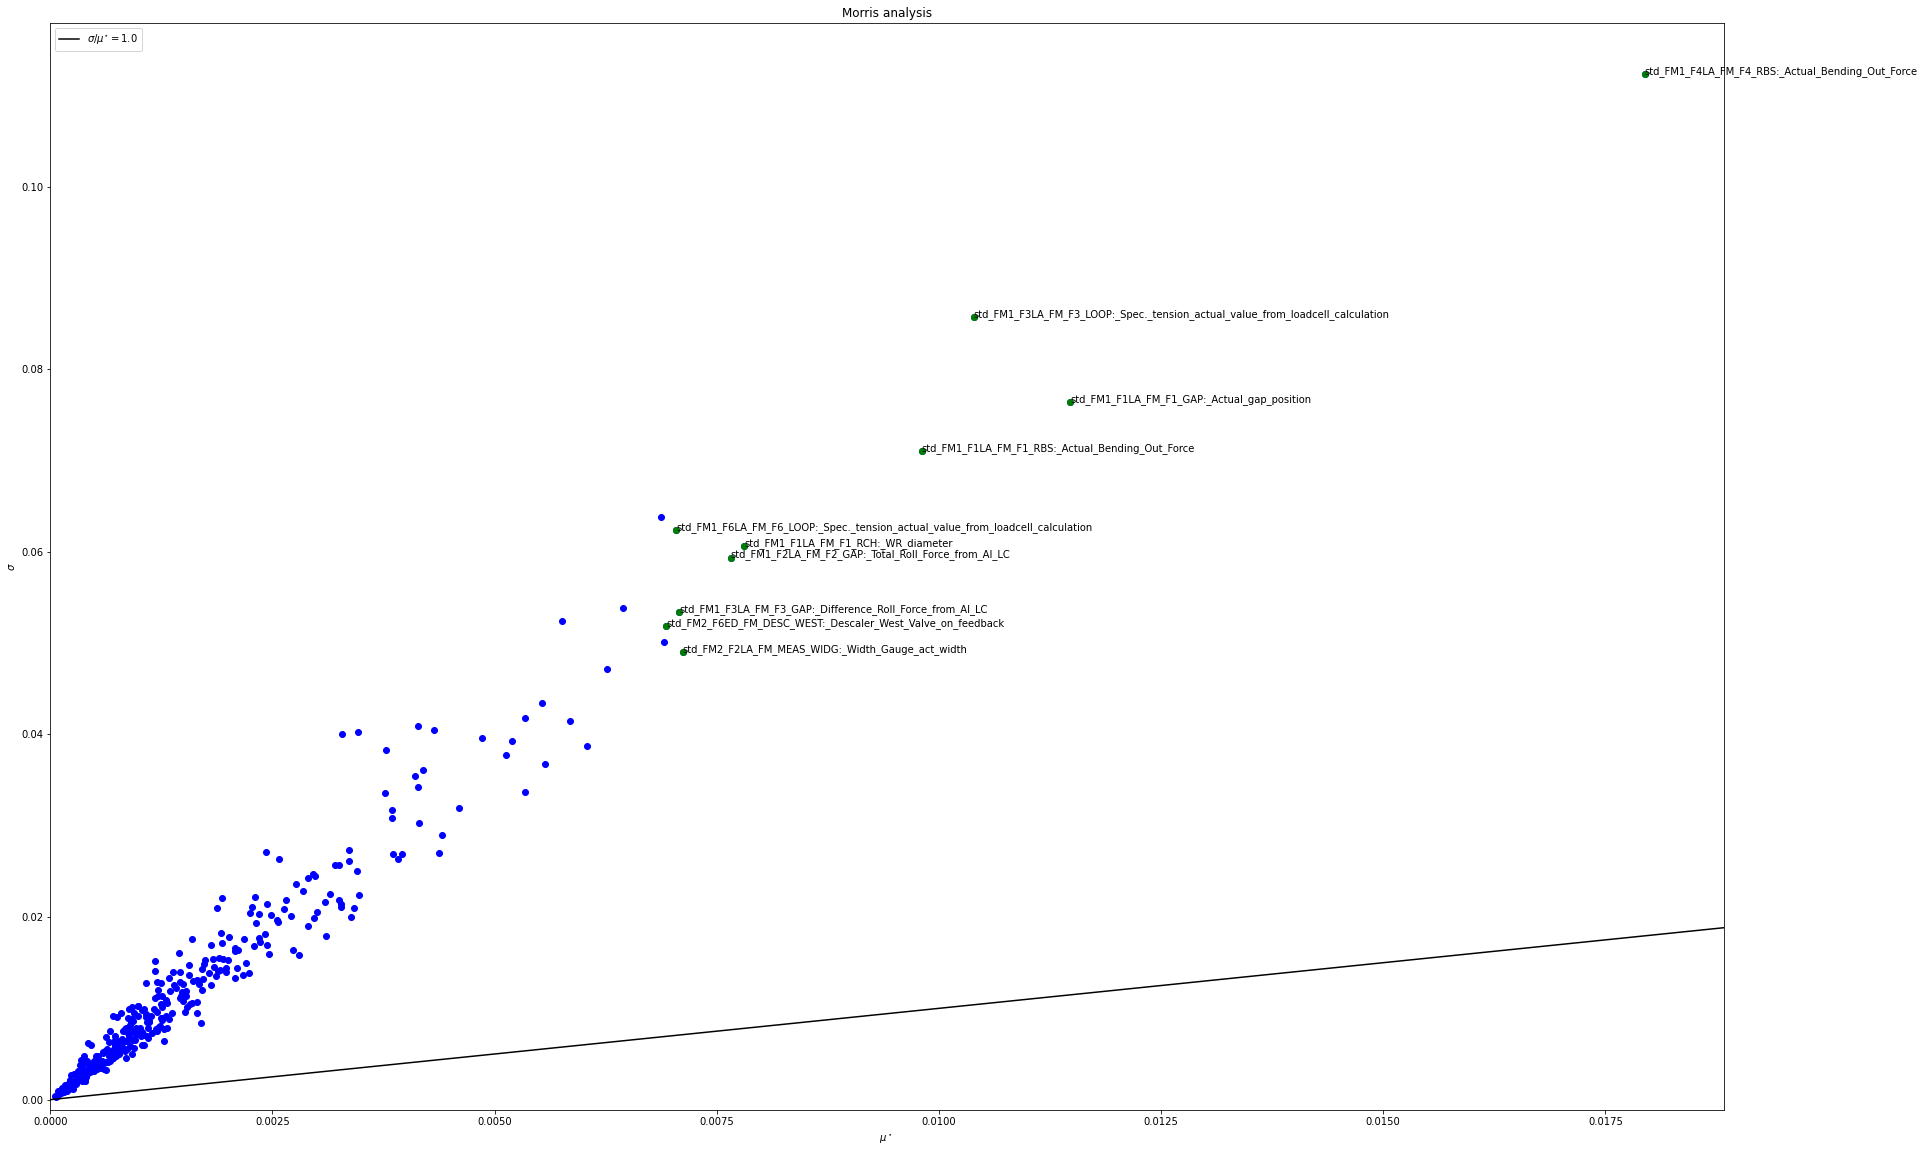

In [ ]:
y = sigma
x = mu_star

fig, ax = plt.subplots(1, 1, figsize=(30, 20))

ax.scatter(x, y, c=u'b', marker=u'o')

ax.set_ylabel(r'$\sigma$')
ax.set_xlim(0,)
ax.set_ylim(0,)

x_axis_bounds = np.array(ax.get_xlim())

line1 = ax.plot(x_axis_bounds, x_axis_bounds, 'k-', label = r'$\sigma / \mu^{\star} = 1.0$')


for i in range(len(indlist)):
    ax.annotate(names[i], (x[i], y[i]))
    ax.scatter(x[i], y[i], c=u'r', marker=u'o')

    print('mu_star: {}, sigma: {}'.format(x[i],y[i]))

ys = sigma_sorted[-10:]
xs = mu_star_sorted[-10:]
names = names_sorted[-10:]
for i, txt in enumerate(names):
    ax.annotate(txt, (xs[i], ys[i]))
    ax.scatter(xs[i], ys[i], c=u'g', marker=u'o')

unit=''
ax.set_xlabel(r'$\mu^\star$ ' + unit)
ax.set_ylim(0-(0.01 * np.array(ax.get_ylim()[1])), )

ax.set_title('Morris analysis')
ax.legend( loc='upper left')

plt.show()

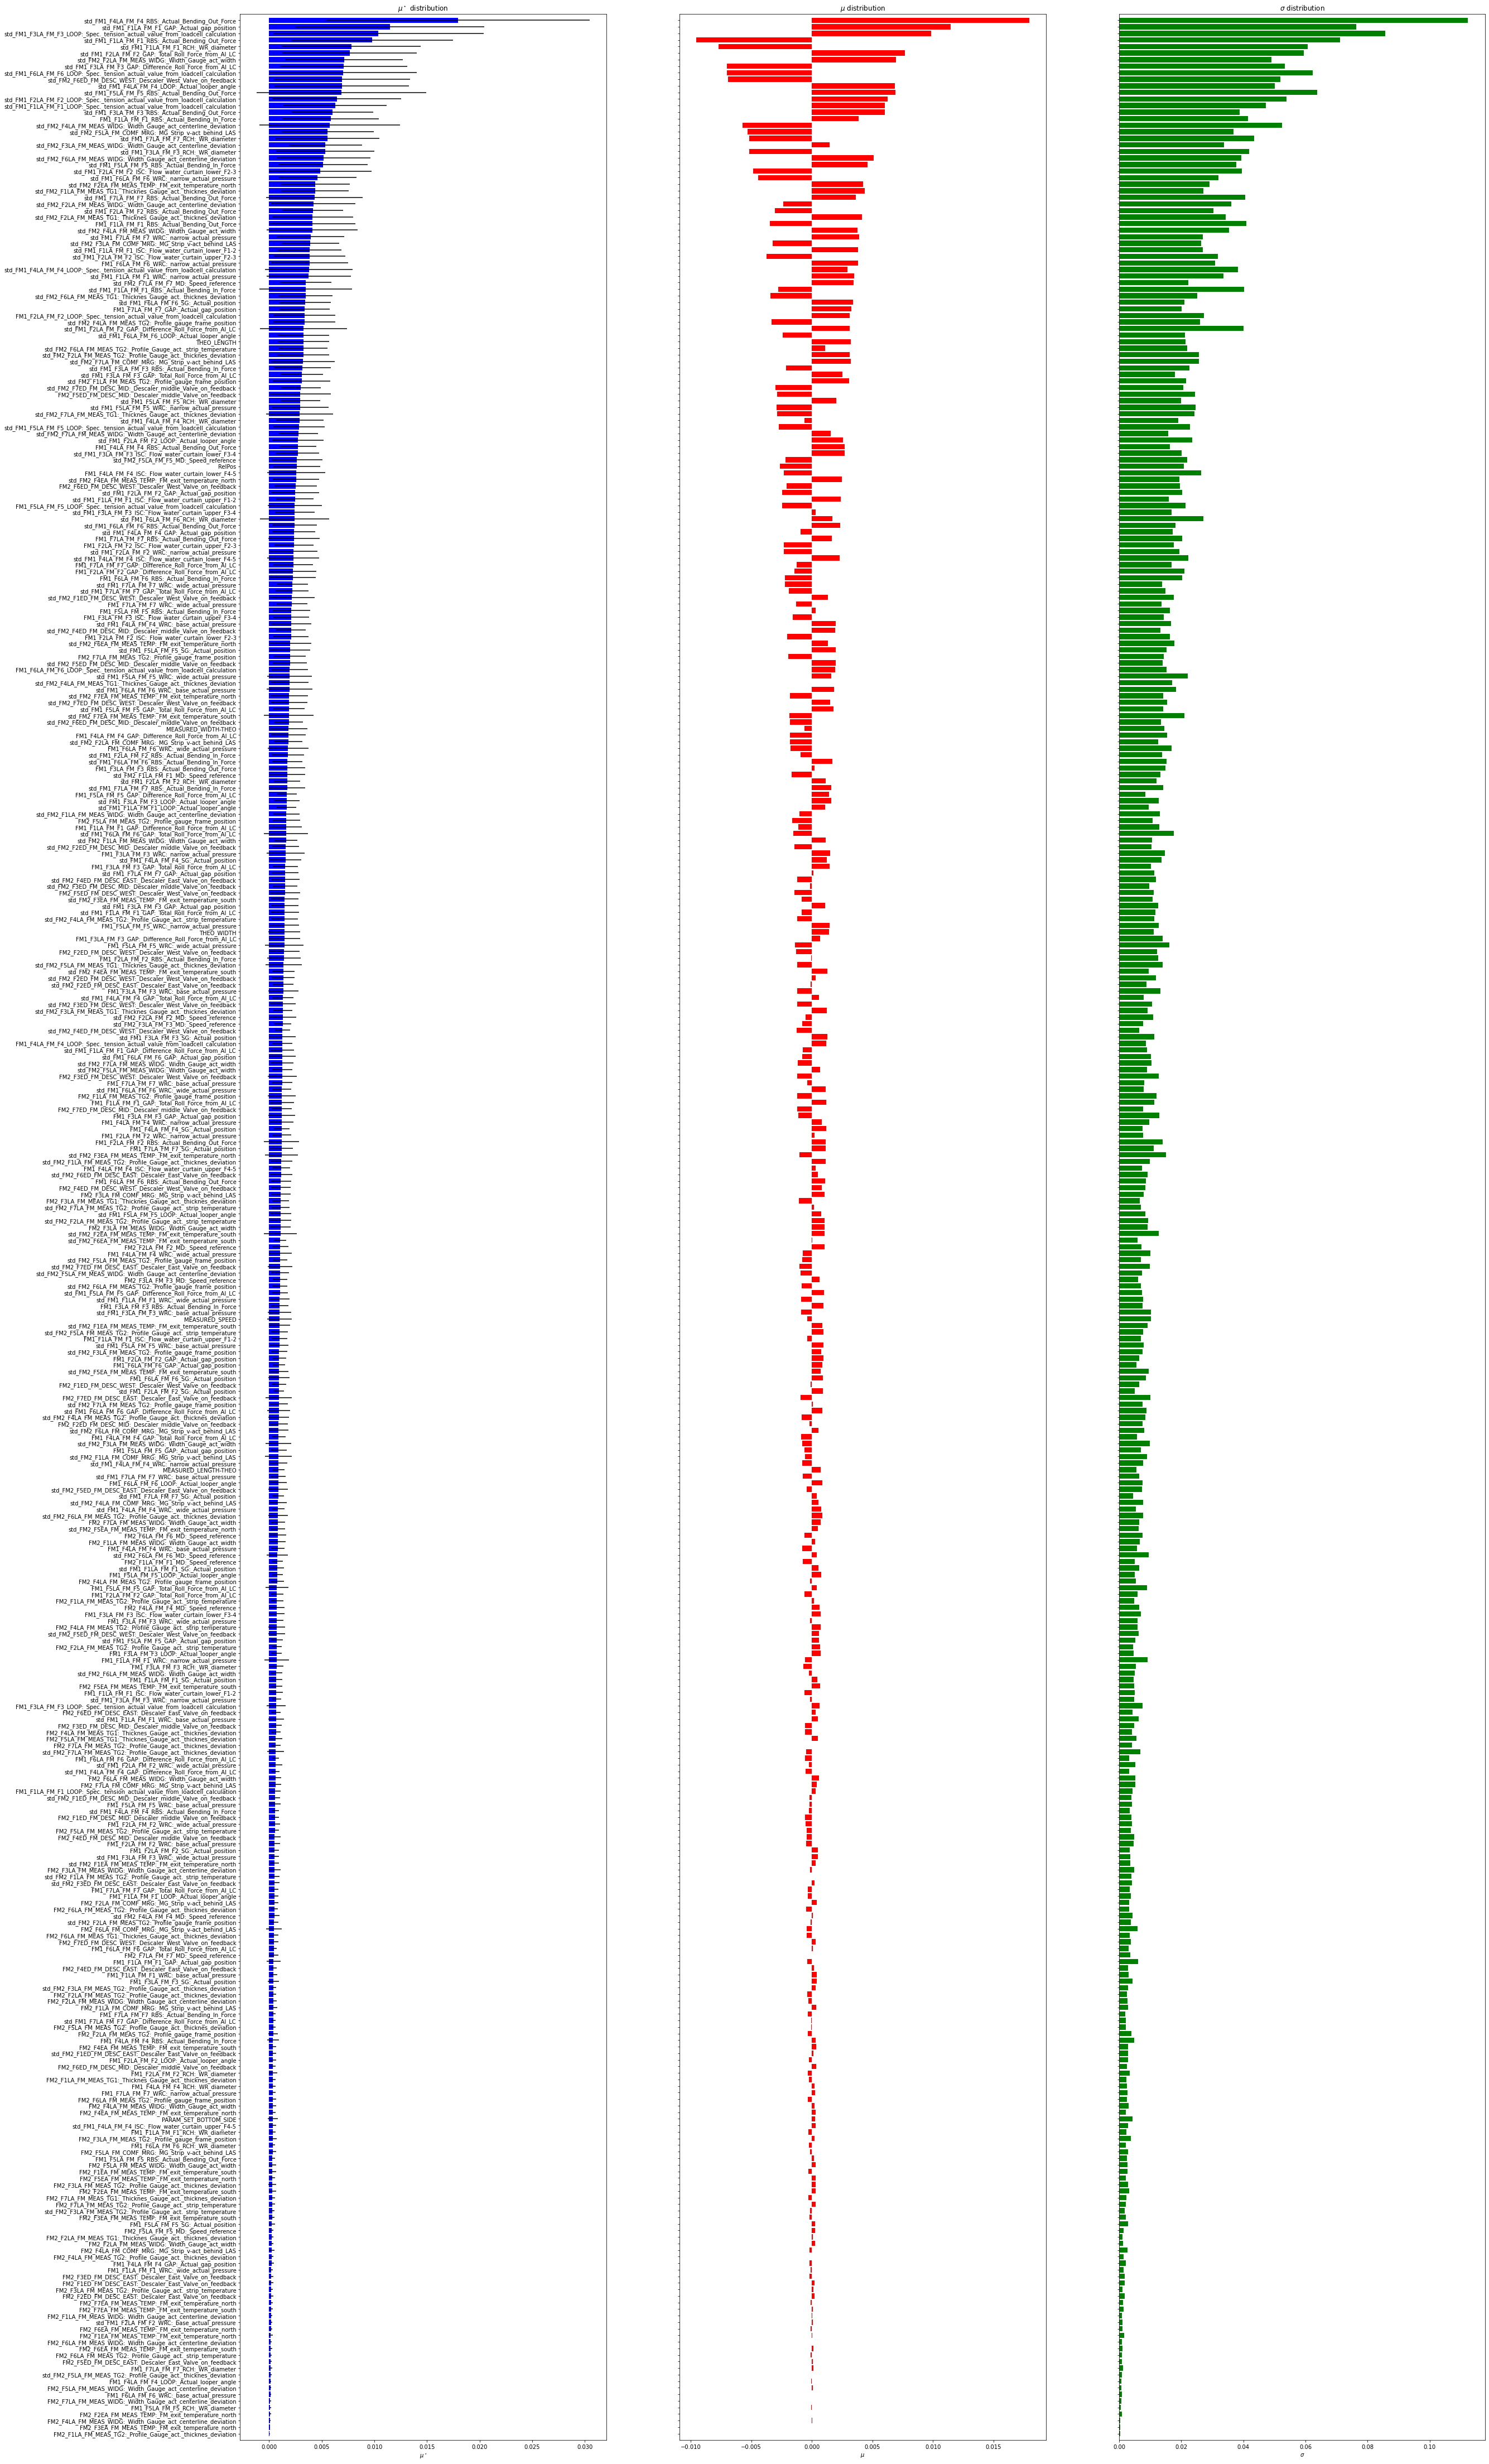

In [ ]:
# Plot horizontal barchart
y_pos = np.arange(len(names_sorted))
plot_names = names_sorted

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40, 80), sharey=True)

ax1.barh(y_pos,
         mu_star_sorted,
         xerr=mu_star_conf_sorted,
         align='center',
         ecolor='black',
         color='blue')

ax2.barh(y_pos,
         mu_sorted,
         align='center',
         ecolor='black',
         color='red')

ax3.barh(y_pos,
         sigma_sorted,
         align='center',
         ecolor='black',
         color='green')

# plot mu_star distribution
ax1.set_yticks(y_pos)
ax1.set_yticklabels(plot_names)
ax1.set_xlabel(r'$\mu^\star$')
ax1.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax1.set_title('$\mu^\star$ distribution')

# plot mu distribution
ax2.set_xlabel(r'$\mu$')
ax2.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax2.set_title('$\mu$ distribution')

# plot sigma distribution
ax3.set_xlabel(r'$\sigma$')
ax3.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax3.set_title('$\sigma$ distribution')

plt.show()

**SOBOL**

* Sobol's method is based on decomposition of the model output variance into summands of variances of the input parameters in increasing dimensionality. Sobol sensitivity analysis determines the contribution of each input parameter and their interactions to the overall model output variance.
* In order to understand how the output variance be attributed to individual input variables and the interaction between each of the input variables, the , first‐order  (S1) , second‐order  (S2) , total‐order  (ST) and higher‐order sensitivity indices are calculated to accurately reflect the influence of the individual input, and the interaction between them.

In [ ]:
## 2- Sobol
from SALib.sample import saltelli
from SALib.analyze import sobol

X = saltelli.sample(problem, 100, calc_second_order=True)
Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()

si_sobol = sobol.analyze(problem, Y, print_to_console=False)

In [ ]:
si_sobol.keys()

dict_keys(['S1', 'S1_conf', 'ST', 'ST_conf', 'S2', 'S2_conf'])

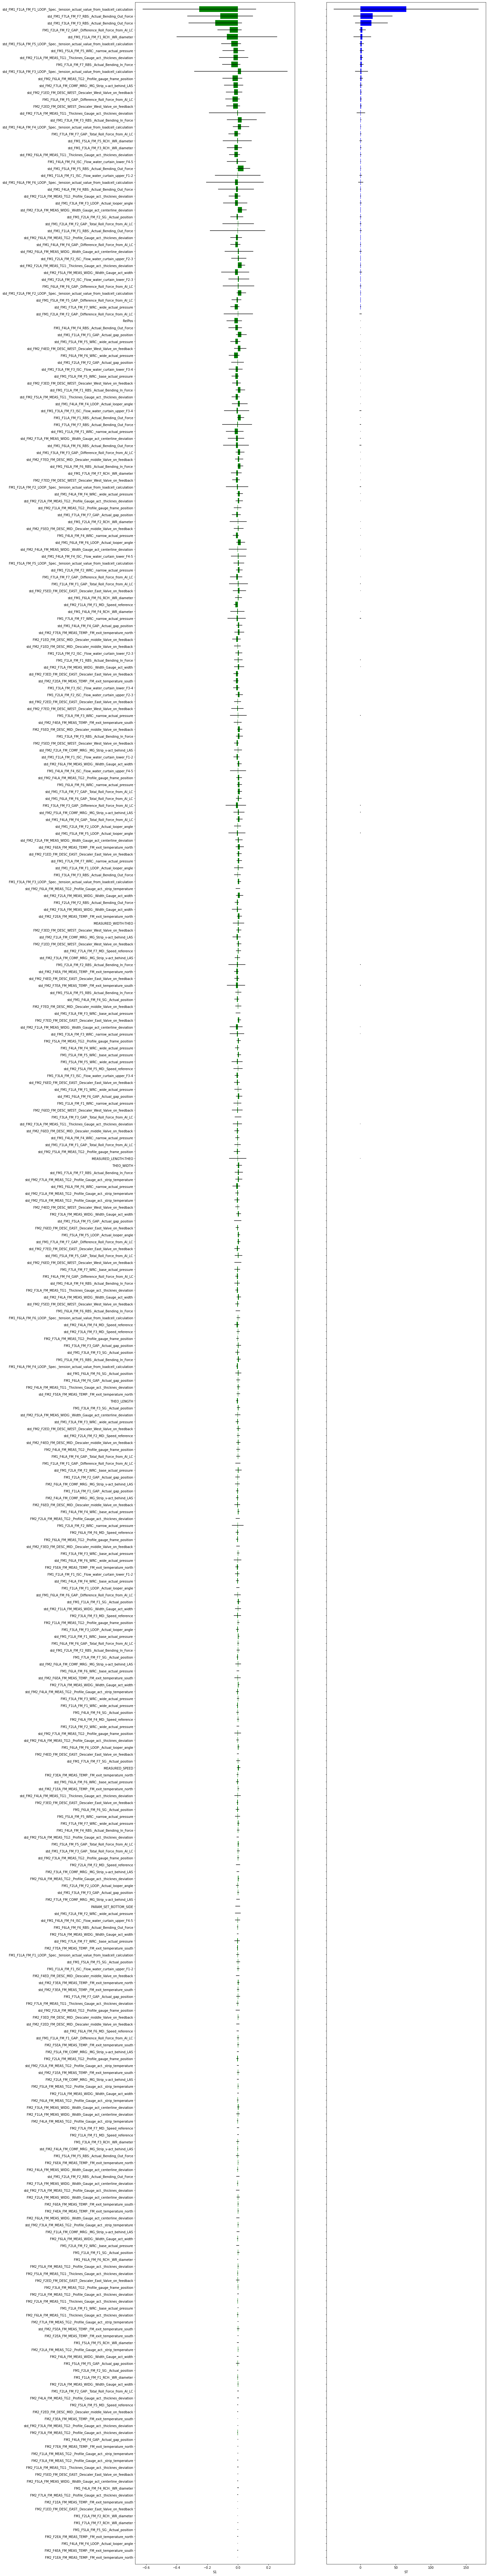

NameError: ignored

In [ ]:
#---Si_sobol plot

Si_key = {k:si_sobol[k] for k in ['S1','S1_conf','ST','ST_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'ST'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'S1', sortcol)
err_sorted = _sort_Si(Si_df, 'S1_conf', sortcol)



val2_sorted = _sort_Si(Si_df, 'ST', sortcol)
err2_sorted = _sort_Si(Si_df, 'ST_conf', sortcol)


fig, ax = plt.subplots(1,2,figsize=(20,150),sharey=True)
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted

ax[0].barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black',
              color='green')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(plot_names)
ax[0].set_xlabel('S1')
ax[0].set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))

ax[1].barh(y_pos,
              val2_sorted,
              xerr=err2_sorted,
              align='center',
              ecolor='black',
              color='blue')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(plot_names)
ax[1].set_xlabel('ST')
ax[1].set_ylim(min(y_pos)-1, max(y_pos)+1)

plt.show()


In [ ]:
def drawgraphs(SAresults):
    # Get list of parameters
    parameters = list(SAresults['S1'].keys())
    # Set min index value, for the effects to be considered significant
    index_significance_value = 0.01
    
    '''
    Define some general layout settings.
    '''
    node_size_min = 15 # Max and min node size
    node_size_max = 30
    border_size_min = 1 # Max and min node border thickness
    border_size_max = 8
    edge_width_min = 1 # Max and min edge thickness
    edge_width_max = 10
    edge_distance_min = 0.1 # Max and min distance of the edge from the center of the circle
    edge_distance_max = 0.6 # Only applicable to the curved edges
    
    '''
    Set up some variables and functions that will facilitate drawing circles and 
    moving items around.
    '''
    # Define circle center and radius
    center = [0.0,0.0] 
    radius = 1.0
    
    # Function to get distance between two points
    def distance(p1,p2):
        return np.sqrt(((p1-p2)**2).sum())
    
    # Function to get middle point between two points
    def middle(p1,p2):
        return (p1+p2)/2
    
    # Function to get the vertex of a curve between two points
    def vertex(p1,p2,c):
        m = middle(p1,p2)
        curve_direction = c-m
        return m+curve_direction*(edge_distance_min+edge_distance_max*(1-distance(m,c)/distance(c,p1)))
    
    # Function to get the angle of the node from the center of the circle
    def angle(p,c):
        # Get x and y distance of point from center
        [dx,dy] = p-c 
        if dx == 0: # If point on vertical axis (same x as center)
            if dy>0: # If point is on positive vertical axis
                return np.pi/2.
            else: # If point is on negative vertical axis
                return np.pi*3./2.
        elif dx>0: # If point in the right quadrants
            if dy>=0: # If point in the top right quadrant
                return np.arctan(dy/dx)
            else: # If point in the bottom right quadrant
                return 2*np.pi+np.arctan(dy/dx)
        elif dx<0: # If point in the left quadrants
            return np.pi+np.arctan(dy/dx)
    
    '''
    First, set up graph with all parameters as nodes and draw all second order (S2)
    indices as edges in the network. For every S2 index, we need a Source parameter,
    a Target parameter, and the Weight of the line, given by the S2 index itself. 
    '''
    combs = [list(c) for c in list(itertools.combinations(parameters, 2))]
    
    Sources = list(list(zip(*combs))[0])
    Targets = list(list(zip(*combs))[1])
    # Sometimes computing errors produce negative Sobol indices. The following reads
    # in all the indices and also ensures they are between 0 and 1.
    Weights = [max(min(x, 1), 0) for x in [SAresults['S2'][Sources[i]][Targets[i]] for i in range(len(Sources))]]
    Weights = [0 if x < index_significance_value else x for x in Weights]
    
    # Set up graph
    G = nx.Graph()
    # Draw edges with appropriate weight
    for s,t,weight in zip(Sources, Targets, Weights):
        G.add_edges_from([(s,t)], w=weight)
    
    # Generate dictionary of node postions in a circular layout
    Pos = nx.circular_layout(G)
    
    '''
    Normalize node size according to first order (S1) index. First, read in S1 indices,
    ensure they're between 0 and 1 and normalize them within the max and min range
    of node sizes.
    Then, normalize edge thickness according to S2. 
    '''
    # Node size
    first_order = [max(min(x, 1), 0) for x in [SAresults['S1'][key] for key in SAresults['S1']]]
    first_order = [0 if x<index_significance_value else x for x in first_order]
    node_size = [node_size_min*(1 + (node_size_max-node_size_min)*k/max(first_order)) for k in first_order]
    # Node border thickness
    total_order = [max(min(x, 1), 0) for x in [SAresults['ST'][key] for key in SAresults['ST']]]
    total_order = [0 if x<index_significance_value else x for x in total_order]
    border_size = [border_size_min*(1 + (border_size_max-border_size_min)*k/max(total_order)) for k in total_order]
    # Edge thickness
    edge_width = [edge_width_min*((edge_width_max-edge_width_min)*k/max(Weights)) for k in Weights]
    
    '''
    Draw network. This will draw the graph with straight lines along the edges and 
    across the circle. 
    '''    
    # nx.draw_networkx_nodes(G, Pos, node_size=node_size, node_color='#98B5E2', 
    #                        edgecolors='#1A3F7A', linewidths = border_size)
    # nx.draw_networkx_edges(G, Pos, width=edge_width, edge_color='#2E5591', alpha=0.7)
    # names = nx.draw_networkx_labels(G, Pos, font_size=12, font_color='#0B2D61', font_family='sans-serif')
    # for node, text in names.items():
    #     position = (radius*1.1*np.cos(angle(Pos[node],center)), radius*1.1*np.sin(angle(Pos[node],center)))
    #     text.set_position(position)
    #     text.set_clip_on(False)
    # plt.gcf().set_size_inches(20, 20) # Make figure a square
    # plt.axis('off')
    
    '''
     We can now draw the network with curved lines along the edges and across the circle.
     Calculate all distances between 1 node and all the others (all distances are 
     the same since they're in a circle). We'll need this to identify the curves 
     we'll be drawing along the perimeter (i.e. those that are next to each other).
     '''
    min_distance = round(min([distance(Pos[list(G.nodes())[0]],Pos[n]) for n in list(G.nodes())[1:]]), 1)
    
    # Figure to generate the curved edges between two points
    def xy_edge(p1,p2): # Point 1, Point 2
        m = middle(p1,p2) # Get middle point between the two nodes
        # If the middle of the two points falls very close to the center, then the 
        # line between the two points is simply straight
        if distance(m,center)<1e-6:
            xpr = np.linspace(p1[0],p2[0],10)
            ypr = np.linspace(p1[1],p2[1],10)
        # If the distance between the two points is the minimum (i.e. they are next
        # to each other), draw the edge along the perimeter     
        elif distance(p1,p2)<=min_distance:
            # Get angles of two points
            p1_angle = angle(p1,center)
            p2_angle = angle(p2,center)
            # Check if the points are more than a hemisphere apart
            if max(p1_angle,p2_angle)-min(p1_angle,p2_angle) > np.pi:
                radi = np.linspace(max(p1_angle,p2_angle)-2*np.pi,min(p1_angle,p2_angle))
            else:
                radi = np.linspace(min(p1_angle,p2_angle),max(p1_angle,p2_angle))
            xpr = radius*np.cos(radi)+center[0]
            ypr = radius*np.sin(radi)+center[1]  
        # Otherwise, draw curve (parabola)
        else: 
            edge_vertex = vertex(p1,p2,center)
            a = distance(edge_vertex, m)/((distance(p1,p2)/2)**2)
            yp = np.linspace(-distance(p1,p2)/2, distance(p1,p2)/2,100)
            xp = a*(yp**2)
            xp += distance(center,edge_vertex)
            theta_m = angle(middle(p1,p2),center)
            xpr = np.cos(theta_m)*xp - np.sin(theta_m)*yp
            ypr = np.sin(theta_m)*xp + np.cos(theta_m)*yp
            xpr += center[0]
            ypr += center[1]
        return xpr,ypr
      
    '''
    Draw network. This will draw the graph with curved lines along the edges and 
    across the circle. 
    '''
    fig = plt.figure(figsize=(30, 25))
    ax = fig.add_subplot(1,1,1)
    for i, e in enumerate(G.edges()):
        x,y=xy_edge(Pos[e[0]],Pos[e[1]])
        ax.plot(x,y,'-',c='#2E5591',lw=edge_width[i],alpha=0.7)
    for i, n in enumerate(G.nodes()):
        ax.plot(Pos[n][0],Pos[n][1], 'o', c='#98B5E2', markersize=node_size[i]/5, markeredgecolor = '#1A3F7A', markeredgewidth = border_size[i]*1.15)
    
    for i, text in enumerate(G.nodes()):
        if node_size[i]<100:
            position = (radius*1.05*np.cos(angle(Pos[text],center)), radius*1.05*np.sin(angle(Pos[text],center)))
        else:
            position = (radius*1.01*np.cos(angle(Pos[text],center)), radius*1.01*np.sin(angle(Pos[text],center)))
        plt.annotate(text, position, fontsize = 12, color='#0B2D61', family='sans-serif')          
    ax.axis('off')
    ax.set_title('Cord graph for parameters with top {} $ST$ values'.format(len(SAresults['S1'].keys())))
    fig.tight_layout()
    plt.show()

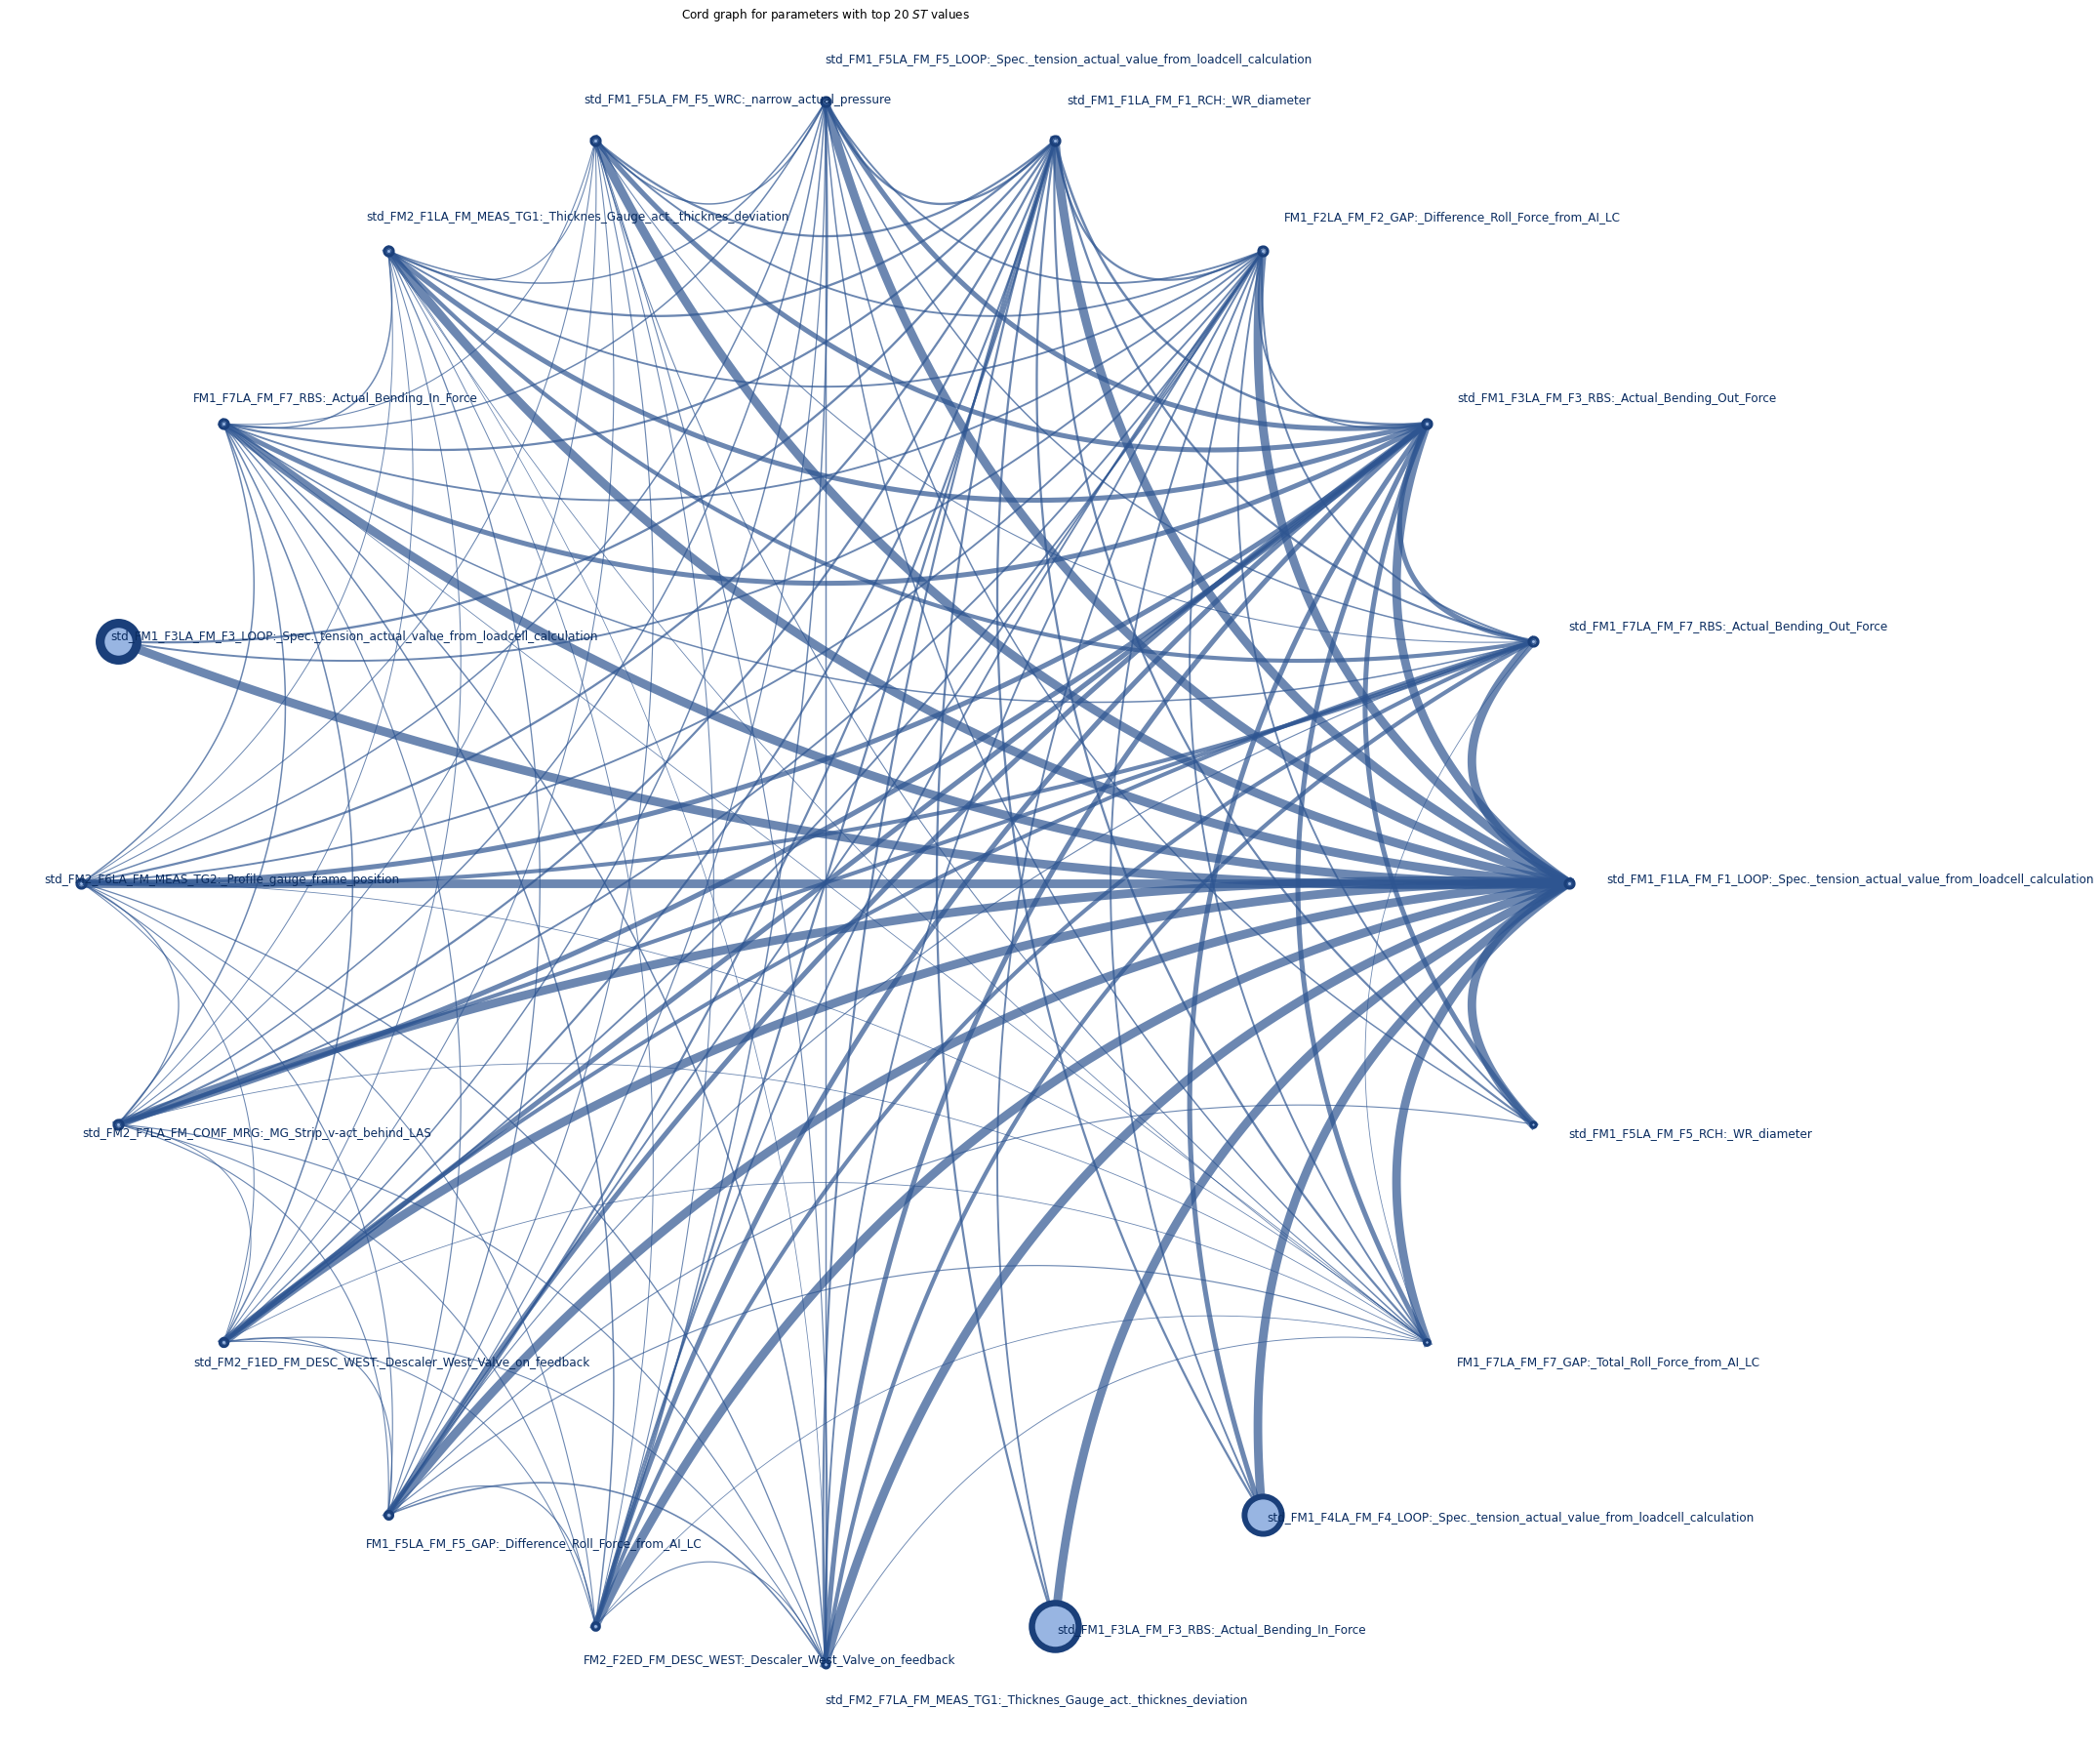

In [ ]:
import itertools
import networkx as nx

def nan_to_zero(si_result):
    for k in si_result.keys():
        si_result[k] = np.nan_to_num(si_result[k])
    return si_result

def S2_to_dict(matrix, problem):
    result = {}
    names = list(problem["names"])
    
    for i in range(problem["num_vars"]):
        for j in range(i+1, problem["num_vars"]):
            if names[i] not in result:
                result[names[i]] = {}
            if names[j] not in result:
                result[names[j]] = {}
            result[names[i]][names[j]] = result[names[j]][names[i]] = float(matrix[i][j])
    return result

def sort_result(result, on='ST', n=30):
    sorted_result = {'S1': {}, 'S1_conf': {}, 'ST': {}, 'ST_conf': {}, 'S2': {}, 'S2_conf': {}}
    if on == 'S2':
        sorted_result = {}
    else:
        sort_keys = [i for i, _ in sorted(result[on].items(), key=lambda x: x[1], reverse=True)]
        topn = sort_keys[:n]
        for k in topn:
            sorted_result['S1'][k] = result['S1'][k]
            sorted_result['S1_conf'][k] = result['S1_conf'][k]
            sorted_result['ST'][k] = result['ST'][k]
            sorted_result['ST_conf'][k] = result['ST_conf'][k]
        for i in topn:
            sorted_result['S2'][i] = {}
            sorted_result['S2_conf'][i] = {}
            for j in topn:
                if i != j:
                    sorted_result['S2'][i][j] = result['S2'][i][j]
                    sorted_result['S2_conf'][i][j] = result['S2_conf'][i][j]
    return sorted_result


# convert nan values to zeros
si_sobol = nan_to_zero(si_sobol)

result = {} #create dictionary to store new
result['S1'] = {k : float(v) for k, v in zip(problem["names"], si_sobol["S1"])}
result['S1_conf'] = {k : float(v) for k, v in zip(problem["names"], si_sobol["S1_conf"])}
result['S2'] = S2_to_dict(si_sobol['S2'], problem)
result['S2_conf'] = S2_to_dict(si_sobol['S2_conf'], problem)
result['ST']={k : float(v) for k, v in zip(problem["names"], si_sobol["ST"])}
result['ST_conf']={k : float(v) for k, v in zip(problem["names"], si_sobol["ST_conf"])}

# plot cord graph of parameters with top 30 ST values
sort_result = sort_result(result, on='ST', n=20)

drawgraphs(sort_result)

**DGSM**

* DGSM is a derivative based method and has lower computational time and is more accurate than Morris
* the computational cost of numerical evaluation of DGSM can be much lower than that for estimation of Sobol’ sensitivity indices.
*   This technique is much more accurate than the Morris method as the elementary effects are evaluated  as  strict  local  derivatives  with  small  increments  compared  to  the  variable uncertainty  ranges. 
* All DGSM measures can be applied for problems with a high number of input variables to reduce the computational time. 
* the numerical efficiency of the DGSM method can be improved by using the automatic differentiation algorithm for calculation DGSM 


In [ ]:
### 3- Derivative-based Global Sensitivity Measure (DGSM)
from SALib.sample import finite_diff
from SALib.analyze import dgsm
param_values = finite_diff.sample(problem, 100, delta=0.001)
Y = clf.predict(param_values)
Y = np.nan_to_num(Y).flatten()

Si_dgsm = dgsm.analyze(problem, param_values, Y, num_resamples=1000, conf_level=0.95, print_to_console=False)
# np.save('dgsm_analysis_'+str(hgroup)+'.npy', Si_dgsm) 


In [ ]:
Si_dgsm.keys()

dict_keys(['vi', 'vi_std', 'dgsm', 'dgsm_conf', 'names'])

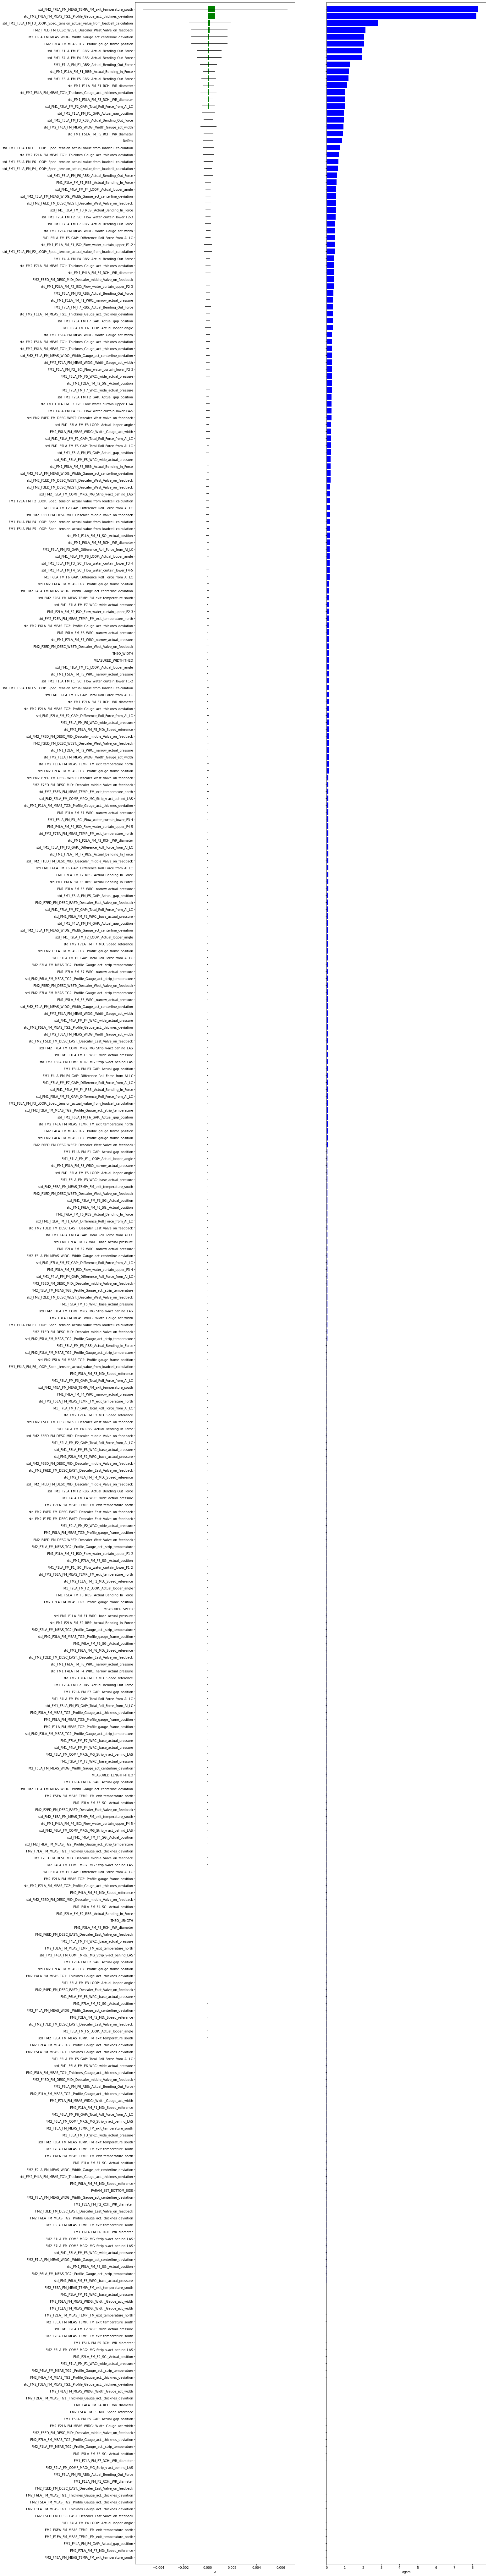

In [ ]:
#---dgsm plot

Si_key = {k:Si_dgsm[k] for k in ['vi','vi_std','dgsm','dgsm_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'vi'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'vi', sortcol)
err_sorted = _sort_Si(Si_df, 'vi_std', sortcol)


# sortcol = 'dgsm'
# names_sorted = _sort_Si(Si_df, 'names',sortcol)
val2_sorted = _sort_Si(Si_df, 'dgsm', sortcol)
err2_sorted = _sort_Si(Si_df, 'dgsm_conf', sortcol)


fig, ax = plt.subplots(1,2,figsize=(20,150),sharey=True)
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted

ax[0].barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black',
              color='green')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(plot_names)
ax[0].set_xlabel('vi')
ax[0].set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))

ax[1].barh(y_pos,
              val2_sorted,
              xerr=err2_sorted,
              align='center',
              ecolor='black',
              color='blue')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabelSi_dgsms(plot_names)
ax[1].set_xlabel('dgsm')
ax[1].set_ylim(min(y_pos)-1, max(y_pos)+1)

plt.show()

**FAST**

* FAST is based on multi-dimmensional Fourier
transform and reduces the cost of sampling computation
* using multiple Fourier series, FAST applies a decomposition of variance  which allows to consider higher-order SIs. 
* FAST is computationally efficient and can be used for nonlinear and non-monotonic models.



In [ ]:
### 4- FAST - Fourier Amplitude Sensitivity Test
from SALib.sample import fast_sampler
from SALib.analyze import fast

param_values = fast_sampler.sample(problem,1000)
Y = clf.predict(param_values)
Y = np.nan_to_num(Y).flatten()
Si_fast = fast.analyze(problem, Y, print_to_console=False)

In [ ]:
Si_fast.keys()

dict_keys(['S1', 'ST', 'names'])

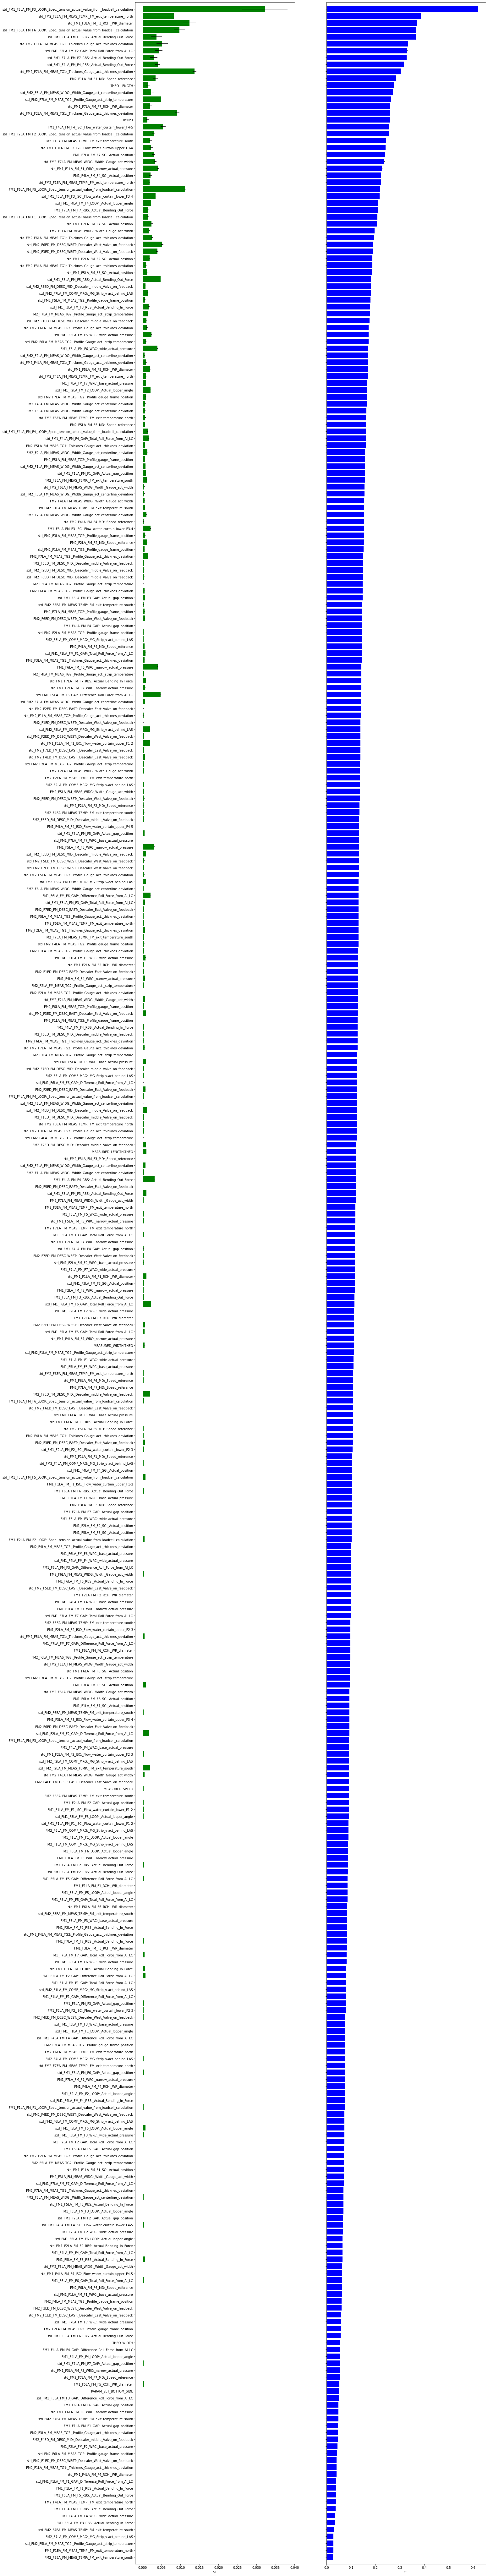

In [ ]:
#---fast plot

Si_key = {k:Si_fast[k] for k in ['S1', 'ST']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'ST'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'S1', sortcol)


val2_sorted = _sort_Si(Si_df, 'ST', sortcol)


fig, ax = plt.subplots(1,2,figsize=(20,150),sharey=True)
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted

ax[0].barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black',
              color='green')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(plot_names)
ax[0].set_xlabel('S1')
ax[0].set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))

ax[1].barh(y_pos,
              val2_sorted,
              xerr=err2_sorted,
              align='center',
              ecolor='black',
              color='blue')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(plot_names)
ax[1].set_xlabel('ST')
ax[1].set_ylim(min(y_pos)-1, max(y_pos)+1)

plt.show()

**RBD-FAST**

* FAST remains costly, unstable and biased when the number of inputs increases (larger than 10)
in practice, many sources of error occur in FAST and it is generally impossible to get accurate estimates at low computational cost. 
* as a consequence, FAST has only been applied to estimate first-order and total SIs in small dimmension
* The RBD and Hybrid FAST-RBD (HFR) methods, partially overcome the inherent drawbacks of FAST using a new sampling technique based on Satterthwaite’s random balance designs. 
* RBD-FAST reduces significantly the computational cost of the global sensitivity analysis.

In [ ]:
#### 5- RBD-FAST - Random Balance Designs Fourier Amplitude Sensitivity Test
from SALib.sample import latin
from SALib.analyze import rbd_fast
X = latin.sample(problem,100)
Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()
Si_rbd = rbd_fast.analyze(problem,X, Y, print_to_console=False)

In [ ]:
Si_rbd.keys()

dict_keys(['S1', 'names'])

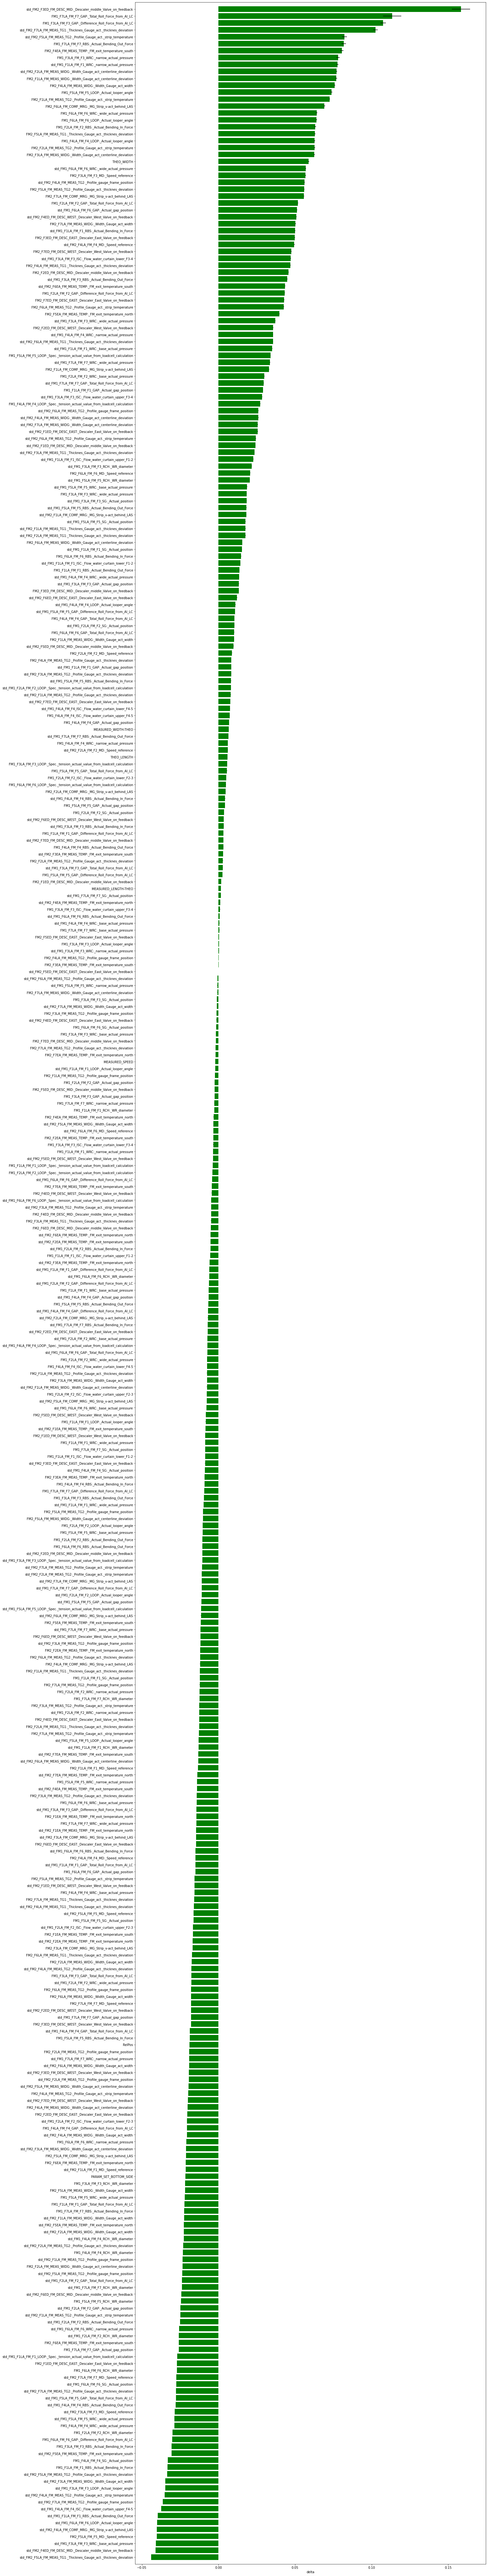

In [ ]:
#---fast-rbd plot

Si_key = {k:Si_rbd[k] for k in [ 'S1']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'S1'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'S1', sortcol)




fig, ax = plt.subplots(1,1,figsize=(20,150),sharey=True)
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted

ax.barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black',
              color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_names)
ax.set_xlabel('delta')
ax.set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))


plt.show()

**Delta**

* Delta is a density based sensitivity method
* Delta method is independnt of sampling generation method (Latin, Monte Carlo)
* It measures the influence of input uncertainty on the entire output distribution without reference to a specific moment of the output (moment independence) 
* variance based methods implicitly assume that variance is sufficient to describe the output variablity. They rest on the assumption of independent inputs. This limitation appears when there is correlations among inputs.


In [ ]:
#### 6- Delta Moment-Independent Measure
from SALib.sample import latin
from SALib.analyze import delta
X = latin.sample(problem,100)
Y = clf.predict(X)
Y = np.nan_to_num(Y).flatten()
Si_delta = delta.analyze(problem,X, Y, print_to_console=False)

In [ ]:
Si_delta.keys()

dict_keys(['delta', 'delta_conf', 'S1', 'S1_conf', 'names'])

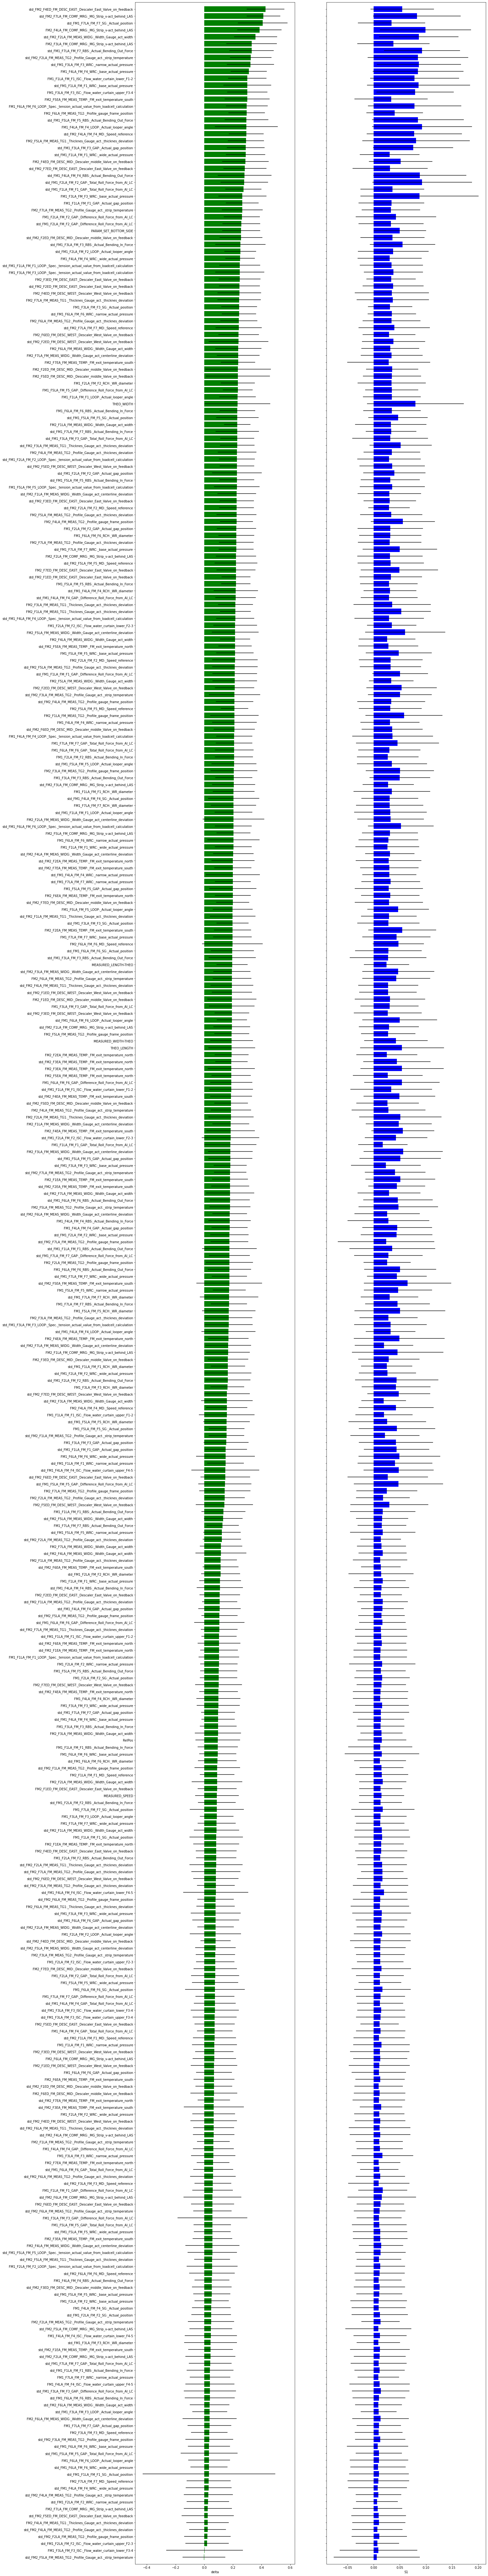

In [ ]:
#---Si_delta plot

Si_key = {k:Si_delta[k] for k in ['delta', 'delta_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(Si_key, index=problem['names'])

Si_df['names']=problem['names']

sortcol = 'delta'
names_sorted = _sort_Si(Si_df, 'names',sortcol)
val_sorted = _sort_Si(Si_df, 'delta', sortcol)
err_sorted = _sort_Si(Si_df, 'delta_conf', sortcol)


val2_sorted = _sort_Si(Si_df, 'S1', sortcol)
err2_sorted = _sort_Si(Si_df, 'S1_conf', sortcol)


fig, ax = plt.subplots(1,2,figsize=(20,150),sharey=True)
# plt.xlim([-0.5,0.5])
# fig.set_size_inches(2,150)


y_pos = np.arange(len(val_sorted))
plot_names = names_sorted

ax[0].barh(y_pos,
              val_sorted,
              xerr=err_sorted,
              align='center',
              ecolor='black',
              color='green')
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(plot_names)
ax[0].set_xlabel('delta')
ax[0].set_ylim(min(y_pos)-1, max(y_pos)+1)

y_pos = np.arange(len(val_sorted))

ax[1].barh(y_pos,
              val2_sorted,
              xerr=err2_sorted,
              align='center',
              ecolor='black',
              color='blue')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(plot_names)
ax[1].set_xlabel('S1')
ax[1].set_ylim(min(y_pos)-1, max(y_pos)+1)

plt.show()
